# 4-7. 프로젝트: CutMix 또는 Mixup 비교실험 하기

## 목차

0. 데이터셋 준비
1. Augmentation을 적용한 데이터셋 만들기
2. 모델 만들기
3. 모델 훈련하기
4. 훈련 과정 시각화하기
5. Augmentation에 의한 모델 성능 비교
6. 데이터 증강을 통한 성능 향상을 위한 다양한 시도
7. 회고


## 루브릭

|평가문항|상세기준|
|:----|:----|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함|
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|

## 0. 데이터셋 준비

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

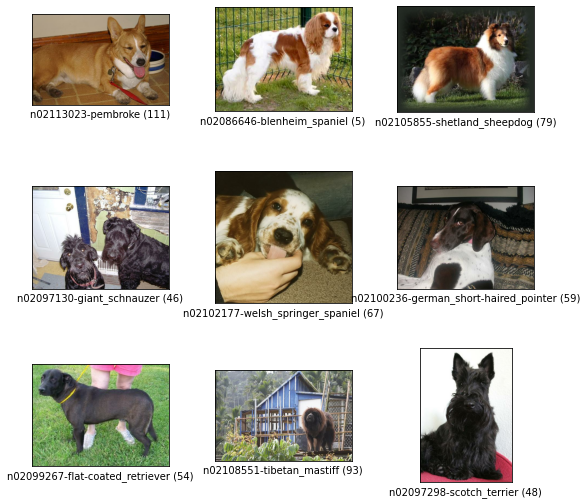

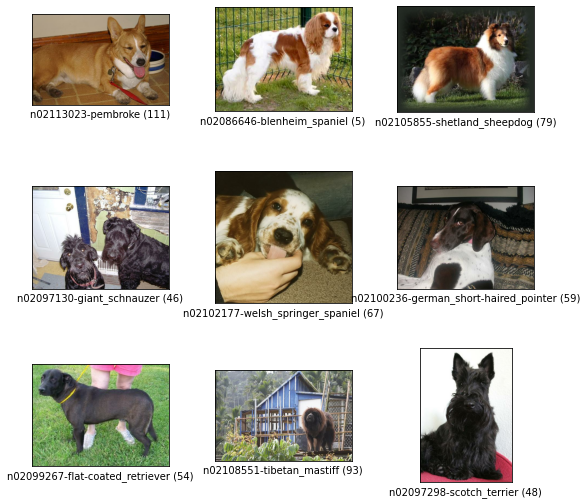

In [4]:
tfds.show_examples(ds_train, ds_info)

## 1. Augmentation을 적용한 데이터셋 만들기

In [50]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.4)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

### Cutmix Augmentation

In [6]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [7]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [8]:
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [9]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup Augmentation

In [10]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [11]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [12]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [81]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
num_classes = ds_info.features["label"].num_classes
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

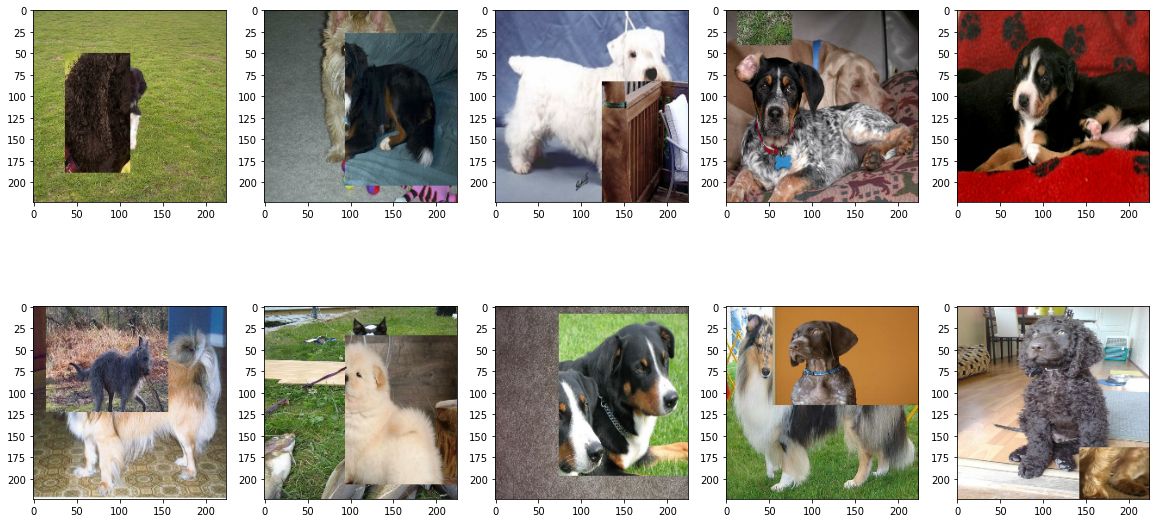

In [15]:
plt.figure(figsize=(20, 10))
for i, (img, label) in enumerate(ds_train_cutmix.take(10)):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i])

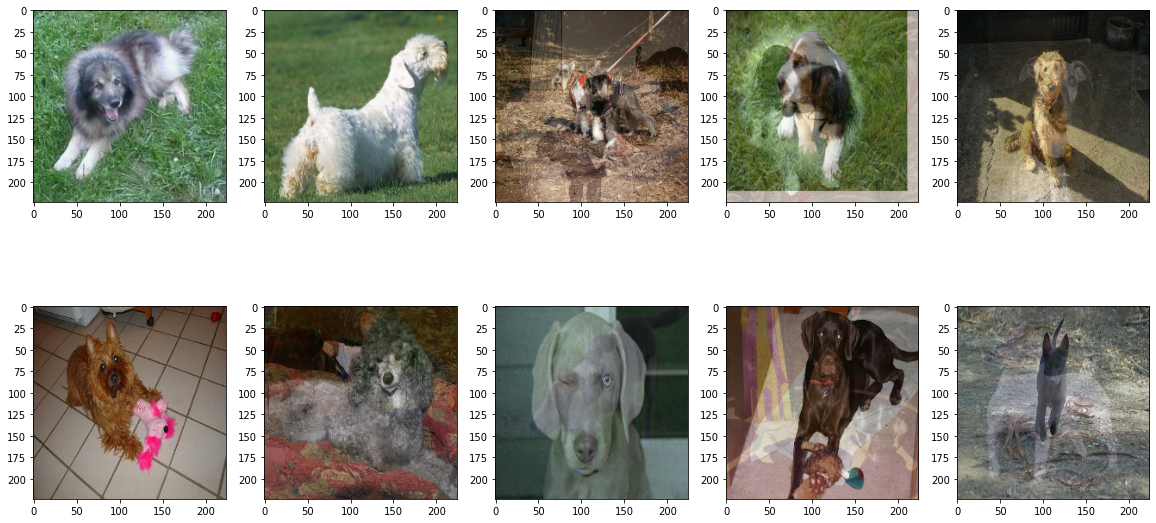

In [16]:
plt.figure(figsize=(20, 10))
for i, (img, label) in enumerate(ds_train_mixup.take(10)):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i])

## 2. 모델 만들기

In [25]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [26]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [27]:
cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [28]:
mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## 3. 모델 훈련하기

In [29]:
EPOCH = 10

In [30]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 94s 117ms/step - loss: 2.2033 - accuracy: 0.4375 - val_loss: 3.7737 - val_accuracy: 0.1426
Epoch 2/10
750/750 [==============================] - 88s 118ms/step - loss: 0.6919 - accuracy: 0.8125 - val_loss: 1.1138 - val_accuracy: 0.6702
Epoch 3/10
750/750 [==============================] - 88s 118ms/step - loss: 0.1897 - accuracy: 0.9652 - val_loss: 0.9328 - val_accuracy: 0.7262
Epoch 4/10
750/750 [==============================] - 88s 118ms/step - loss: 0.0495 - accuracy: 0.9959 - val_loss: 0.8996 - val_accuracy: 0.7344
Epoch 5/10
750/750 [==============================] - 88s 118ms/step - loss: 0.0206 - accuracy: 0.9995 - val_loss: 0.9225 - val_accuracy: 0.7345
Epoch 6/10
750/750 [==============================] - 88s 117ms/step - loss: 0.0131 - accuracy: 0.9998 - val_loss: 0.9373 - val_accuracy: 0.7346
Epoch 7/10
750/750 [==============================] - 88s 118ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.9448 - val_accuracy: 0.7

In [31]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 95s 118ms/step - loss: 2.2806 - accuracy: 0.4277 - val_loss: 3.1198 - val_accuracy: 0.2379
Epoch 2/10
750/750 [==============================] - 88s 117ms/step - loss: 0.9223 - accuracy: 0.7387 - val_loss: 1.5773 - val_accuracy: 0.5625
Epoch 3/10
750/750 [==============================] - 88s 117ms/step - loss: 0.4825 - accuracy: 0.8700 - val_loss: 1.0936 - val_accuracy: 0.6856
Epoch 4/10
750/750 [==============================] - 88s 117ms/step - loss: 0.2456 - accuracy: 0.9442 - val_loss: 1.4115 - val_accuracy: 0.6227
Epoch 5/10
750/750 [==============================] - 88s 117ms/step - loss: 0.1245 - accuracy: 0.9797 - val_loss: 0.9937 - val_accuracy: 0.7218
Epoch 6/10
750/750 [==============================] - 87s 117ms/step - loss: 0.1057 - accuracy: 0.9818 - val_loss: 0.9891 - val_accuracy: 0.7252
Epoch 7/10
750/750 [==============================] - 88s 117ms/step - loss: 0.0541 - accuracy: 0.9927 - val_loss: 0.9819 - val_accuracy: 0.7

In [32]:
cutmix_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_aug_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
750/750 [==============================] - 98s 121ms/step - loss: 3.8480 - accuracy: 0.2066 - val_loss: 3.2097 - val_accuracy: 0.2333
Epoch 2/10
750/750 [==============================] - 90s 120ms/step - loss: 2.9606 - accuracy: 0.4301 - val_loss: 1.3778 - val_accuracy: 0.6238
Epoch 3/10
750/750 [==============================] - 90s 121ms/step - loss: 2.6358 - accuracy: 0.5312 - val_loss: 1.3234 - val_accuracy: 0.6419
Epoch 4/10
750/750 [==============================] - 91s 121ms/step - loss: 2.4370 - accuracy: 0.5951 - val_loss: 1.2063 - val_accuracy: 0.6552
Epoch 5/10
750/750 [==============================] - 91s 121ms/step - loss: 2.2455 - accuracy: 0.6570 - val_loss: 1.3502 - val_accuracy: 0.6348
Epoch 6/10
750/750 [==============================] - 91s 121ms/step - loss: 2.1383 - accuracy: 0.6862 - val_loss: 1.5478 - val_accuracy: 0.5944
Epoch 7/10
750/750 [==============================] - 90s 121ms/step - loss: 2.0522 - accuracy: 0.7190 - val_loss: 1.2487 - val_ac

In [33]:
mixup_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_aug_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 97s 121ms/step - loss: 3.7242 - accuracy: 0.2434 - val_loss: 3.9520 - val_accuracy: 0.1309
Epoch 2/10
750/750 [==============================] - 95s 127ms/step - loss: 2.8508 - accuracy: 0.4735 - val_loss: 1.7730 - val_accuracy: 0.5169
Epoch 3/10
750/750 [==============================] - 91s 121ms/step - loss: 2.5707 - accuracy: 0.5892 - val_loss: 1.5513 - val_accuracy: 0.5736
Epoch 4/10
750/750 [==============================] - 91s 121ms/step - loss: 2.3816 - accuracy: 0.6630 - val_loss: 1.3077 - val_accuracy: 0.6423
Epoch 5/10
750/750 [==============================] - 91s 121ms/step - loss: 2.2338 - accuracy: 0.7157 - val_loss: 1.2596 - val_accuracy: 0.6445
Epoch 6/10
750/750 [==============================] - 95s 127ms/step - loss: 2.1515 - accuracy: 0.7560 - val_loss: 1.2741 - val_accuracy: 0.6498
Epoch 7/10
750/750 [==============================] - 91s 121ms/step - loss: 2.0476 - accuracy: 0.7803 - val_loss: 1.2634 - val_accuracy: 0.6

## 4. 훈련 과정 시각화하기

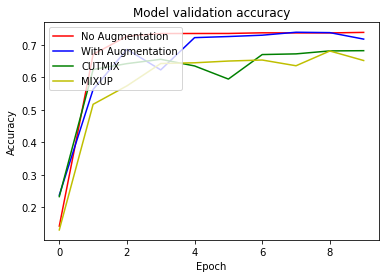

In [34]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CUTMIX', 'MIXUP'], loc='upper left')
plt.show()

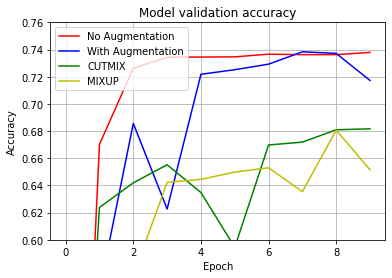

In [36]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CUTMIX', 'MIXUP'], loc='upper left')
plt.grid(True)
# plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.60, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## 5. Augmentation에 의한 모델 성능 비교

In [37]:
# 데이터 프레임으로 만들어서 비교
df = pd.DataFrame({'No Augmentation':history_resnet50_no_aug.history['val_accuracy'],
                           'With Augmentation':history_resnet50_aug.history['val_accuracy'],
                           'CUTMIX':history_resnet50_cutmix.history['val_accuracy'],
                           'MIXUP':history_resnet50_mixup.history['val_accuracy']
                           })
df

,No Augmentation,With Augmentation,CUTMIX,MIXUP
0,0.142607,0.237873,0.233326,0.130947
1,0.670243,0.562500,0.623834,0.516908
2,0.726213,0.685634,0.641908,0.573577
3,0.734375,0.622668,0.655201,0.642257
4,0.734492,0.721782,0.634795,0.644473
5,0.734608,0.725163,0.594450,0.649837
6,0.736591,0.729244,0.669776,0.652985
7,0.736241,0.738340,0.671875,0.635378
8,0.736241,0.737173,0.680970,0.680737
9,0.737873,0.717234,0.681670,0.651469


### 기본 + CUTMIX, 기본 + MIXUP

In [38]:
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

In [43]:
cutmixaug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [45]:
mixupaug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [44]:
cutmixaug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_cutmixaug_resnet50 = cutmixaug_resnet50.fit(
    ds_train_aug_cutmix, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
750/750 [==============================] - 99s 122ms/step - loss: 3.8952 - accuracy: 0.1942 - val_loss: 3.4704 - val_accuracy: 0.1954
Epoch 2/10
750/750 [==============================] - 89s 119ms/step - loss: 3.0546 - accuracy: 0.4022 - val_loss: 1.4140 - val_accuracy: 0.6011
Epoch 3/10
750/750 [==============================] - 89s 119ms/step - loss: 2.7516 - accuracy: 0.4974 - val_loss: 1.1847 - val_accuracy: 0.6602
Epoch 4/10
750/750 [==============================] - 89s 119ms/step - loss: 2.5808 - accuracy: 0.5396 - val_loss: 1.1494 - val_accuracy: 0.6732
Epoch 5/10
750/750 [==============================] - 89s 119ms/step - loss: 2.4480 - accuracy: 0.5872 - val_loss: 1.1683 - val_accuracy: 0.6799
Epoch 6/10
750/750 [==============================] - 90s 120ms/step - loss: 2.3464 - accuracy: 0.6191 - val_loss: 1.2658 - val_accuracy: 0.6648
Epoch 7/10
750/750 [==============================] - 90s 120ms/step - loss: 2.2273 - accuracy: 0.6599 - val_loss: 1.1931 - val_ac

In [46]:
mixupaug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_mixupaug_resnet50 = mixupaug_resnet50.fit(
    ds_train_aug_mixup, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 100s 122ms/step - loss: 3.7733 - accuracy: 0.2256 - val_loss: 3.9768 - val_accuracy: 0.1236
Epoch 2/10
750/750 [==============================] - 91s 121ms/step - loss: 2.9378 - accuracy: 0.4430 - val_loss: 1.5233 - val_accuracy: 0.5794
Epoch 3/10
750/750 [==============================] - 90s 121ms/step - loss: 2.6753 - accuracy: 0.5406 - val_loss: 1.4797 - val_accuracy: 0.5899
Epoch 4/10
750/750 [==============================] - 91s 121ms/step - loss: 2.5105 - accuracy: 0.6018 - val_loss: 1.2074 - val_accuracy: 0.6608
Epoch 5/10
750/750 [==============================] - 91s 121ms/step - loss: 2.3982 - accuracy: 0.6501 - val_loss: 1.3089 - val_accuracy: 0.6420
Epoch 6/10
750/750 [==============================] - 90s 121ms/step - loss: 2.2797 - accuracy: 0.6973 - val_loss: 1.1353 - val_accuracy: 0.6887
Epoch 7/10
750/750 [==============================] - 91s 121ms/step - loss: 2.1988 - accuracy: 0.7205 - val_loss: 1.2228 - val_accuracy: 0.

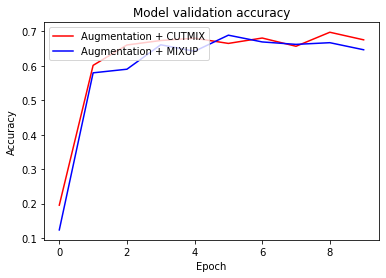

In [47]:
plt.plot(history_cutmixaug_resnet50.history['val_accuracy'], 'r')
plt.plot(history_mixupaug_resnet50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Augmentation + CUTMIX', 'Augmentation + MIXUP'], loc='upper left')
plt.show()

## 데이터 증강을 통한 성능 향상을 위한 다양한 시도

## epoch마다 Random Augmentaion 적용

In [65]:
history_aug = {'accuracy':[],'loss':[],'val_accuracy':[],'val_loss':[]}

In [72]:
aug_test = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

aug_test.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


for _ in range(10):
    ds_train_aug_test = apply_normalize_on_dataset(ds_train, with_aug=True)
    history = aug_test.fit(
        ds_train_aug_test,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=1,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )
    history_aug['accuracy'].append(history.history['accuracy'][0])
    history_aug['loss'].append(history.history['loss'][0])
    history_aug['val_accuracy'].append(history.history['val_accuracy'][0])
    history_aug['loss'].append(history.history['loss'][0])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 89s 116ms/step - loss: 0.0708 - accuracy: 0.9871 - val_loss: 1.1206 - val_accuracy: 0.7015


In [75]:
# 10번 추가 학습
for _ in range(10):
    ds_train_aug_test = apply_normalize_on_dataset(ds_train, with_aug=True)
    history = aug_test.fit(
        ds_train_aug_test, 
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=1,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )
    history_aug['accuracy'].append(history.history['accuracy'][0])
    history_aug['loss'].append(history.history['loss'][0])
    history_aug['val_accuracy'].append(history.history['val_accuracy'][0])
    history_aug['loss'].append(history.history['loss'][0])

750/750 [==============================] - 90s 116ms/step - loss: 0.0115 - accuracy: 0.9987 - val_loss: 1.0676 - val_accuracy: 0.7287


In [76]:
import random

In [135]:
def augment(image, label):
    num = random.randrange(1,5)
    if num == 1:
        image = tf.image.random_flip_left_right(image)
    elif num == 2:
        image = tf.image.random_brightness(image, max_delta=0.4)
    elif num == 3:
        image = tf.image.adjust_saturation(image, 3)
    elif num == 4:
        image = tf.image.random_hue(image, 0.5)
    # elif num == 5:
        # image = tf.image.rgb_to_grayscale(image)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [97]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [98]:
history_radom_aug = {'accuracy':[],'loss':[],'val_accuracy':[],'val_loss':[]}

random_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

random_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [99]:
for _ in range(20):
    ds_train_aug_test = apply_normalize_on_dataset(ds_train, with_aug=True)
    history = random_aug.fit(
        ds_train_aug_test,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=1,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )
    history_radom_aug['accuracy'].append(history.history['accuracy'][0])
    history_radom_aug['loss'].append(history.history['loss'][0])
    history_radom_aug['val_accuracy'].append(history.history['val_accuracy'][0])
    history_radom_aug['loss'].append(history.history['loss'][0])

750/750 [==============================] - 95s 122ms/step - loss: 0.0049 - accuracy: 0.9998 - val_loss: 1.0095 - val_accuracy: 0.7448


In [100]:
# 10 추가 학습
for _ in range(10):
    ds_train_aug_test = apply_normalize_on_dataset(ds_train, with_aug=True)
    history = random_aug.fit(
        ds_train_aug_test, 
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=1,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )
    history_radom_aug['accuracy'].append(history.history['accuracy'][0])
    history_radom_aug['loss'].append(history.history['loss'][0])
    history_radom_aug['val_accuracy'].append(history.history['val_accuracy'][0])
    history_radom_aug['loss'].append(history.history['loss'][0])

750/750 [==============================] - 90s 115ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.0588 - val_accuracy: 0.7481


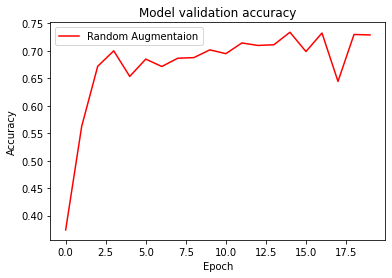

In [140]:
plt.plot(history_aug['val_accuracy'], 'r')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Random Augmentaion'], loc='upper left')
plt.show()

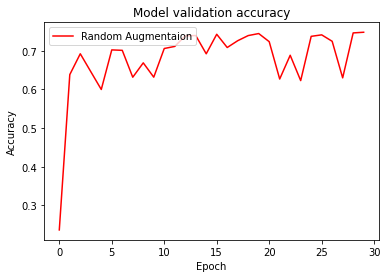

In [139]:
plt.plot(history_radom_aug['val_accuracy'], 'r')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Random Augmentaion'], loc='upper left')
plt.show()

## 또 다른 시도

In [136]:
test = ds_train_no_aug.concatenate(ds_train_aug)
test

<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

In [137]:
test_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

test_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


history_test_aug = test_aug.fit(
    test, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 94s 117ms/step - loss: 2.2150 - accuracy: 0.4442 - val_loss: 2.9637 - val_accuracy: 0.2712
Epoch 2/10
750/750 [==============================] - 87s 116ms/step - loss: 0.6926 - accuracy: 0.8142 - val_loss: 1.0900 - val_accuracy: 0.6813
Epoch 3/10
750/750 [==============================] - 87s 116ms/step - loss: 0.2433 - accuracy: 0.9479 - val_loss: 1.0723 - val_accuracy: 0.6906
Epoch 4/10
750/750 [==============================] - 87s 116ms/step - loss: 0.0657 - accuracy: 0.9934 - val_loss: 0.8975 - val_accuracy: 0.7390
Epoch 5/10
750/750 [==============================] - 87s 116ms/step - loss: 0.0217 - accuracy: 0.9996 - val_loss: 0.8962 - val_accuracy: 0.7445
Epoch 6/10
750/750 [==============================] - 88s 117ms/step - loss: 0.0125 - accuracy: 0.9999 - val_loss: 0.9085 - val_accuracy: 0.7464
Epoch 7/10
750/750 [==============================] - 87s 116ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.9205 - val_accuracy: 0.7

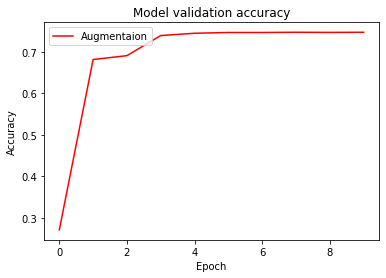

In [141]:
plt.plot(history_test_aug.history['val_accuracy'], 'r')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Augmentaion'], loc='upper left')
plt.show()

## 회고

- 결과
    - 데이터 셋의 증가 방식이 아닌 기본 데이터에서 Augmentation을 적용한 데이터를 만드는 방식이다 보니 Augmentation을 적용하지 않을 경우가 더 잘 나오는 것 같습니다.
    - CutMix와 MixUp 같은 경우 성능이 좋지 못 했습니다.
    - 기본 + CutMix, 기본 + MixUp 같은 경우에도 성능이 좋지 못 했습니다.
    - 성능 향상을 위해서 epoch당 Augmentation을 적용했습니다.
        1. for 루프를 통해서 학습을 시킬 때 train 데이터를 매번 다시 만드는 방법으로 적용하여 훈련하였습니다.
        2. 1번에서 Augmentation을 적용할 때 함수 안에서 랜덤하게 Augmentation 기법을 적용하였습니다.
        - 1번보다 2번이 성능이 더 좋았습니다.
    - 성능 향상을 위해서 concatenate를 이용하여 실험하였습니다.
        - 가장 안정적인 val_accuracy가 나왔습니다. 
- 기타
    - 노드에 나온 함수 중에 전역 변수를 사용하는 함수가 있었습니다. 노드를 따라서 작성하면 크게 문제가 없지만, 이 전역 변수를 사용한 것이 이미지를 확인 할 때 사용하였기 때문에 저는 사용하지 않아서 오류가 발생하였습니다. 그래서 전역 변수를 사용하는 함수를 수정하였습니다.
    - 노드에 나오는 방식으로는 성능 향상이 어려울 것 같습니다.
         - 기본 데이터 + Augmentation 데이터가 아닌 기본을 전부 Augmentation을 적용하는 것이 문제인 것 같습니다.
         - 그래서 다양한 방식으로 성능 향상을 위해 실험하였지만 성능 향상이 되지 않았습니다. 
    - Augmentation을 기본 데이터에 데이터를 늘려 데이터 셋을 늘리는 방법만 생각했습니다. 하지만 epoch마다 Augmentation을 랜덤하게 적용한다면 훈련을 할 때 마다 다른 데이터로 훈련하는 효과를 볼 수 있다는 것을 알게 되었습니다.
    - 어떤 Augmentation 기법을 적용해야 데이터에 문제가 생기지 않을지 많은 생각을 하게 만든 프로젝트인 것 같습니다.
        - central crop 같은 경우 이번 이미지에 적용할 경우 이미지 가운데에 핵심이 없을 경우 불필요한 데이터가 되기 때문에 사용하지 않았습니다. 
